In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

In [4]:
import pandas as pd
import numpy as np
import re
import json

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

data_hist_files = {'A': 'data_file_hist_all_cols', 
                   'B': 'data_file_hist_some_cols',
                   'C': 'data_file_hist_no_lkbk'}

data = []
for c, fname in data_hist_files.items():
    df_hist = pd.read_pickle(f'data/{fname}.pkl')
    test_cols = [d for d in df_hist.columns if d.endswith('test_scores')]
    other_cols = ['pos_labels', 'sim_num_trades', 'sim_max_profit']
    df = df_hist[other_cols + test_cols].copy()
    
    # calculate true positives and false positives
    for i,r in df.iterrows():
        relevant_elements = r[0]
        trades = r[1]
        profit = r[2]
        models = list(r.index)[3:]
        for m in models:
            if pd.isnull(r[m]):
                continue
            d = json.loads(r[m].replace("'",'"'))
            tp = int(d['rc'] * relevant_elements)
            fp = int(tp/d['pr']-tp) if d['pr'] != 0 else 0
            ratio = round(tp/fp,2) if fp>0 else 0
            act_trades = min(trades,tp)
            row = dict(c=c,
                       dataset=i,
                       classifer=m,
                       tp=tp,
                       fp=fp,
                       diff=tp-fp,
                       ratio=ratio,
                       pr=d.get('pr',0),
                       rc=d.get('rc',0),
                       pf=d.get('pf',0),
                       est_max_profit=(profit/trades)*act_trades if trades>0 else 0
                      )
            data.append(row)
df = pd.DataFrame(data)
df = df[(df.classifer == 'lrc_test_scores') & (df.pr > 0)].sort_values(by=['dataset','c']).reset_index(drop=True)
display(df.sort_values(by='pf', ascending=False))
df = df

,c,dataset,classifer,tp,fp,diff,ratio,pr,rc,pf,est_max_profit
13,B,20210806i,lrc_test_scores,840,631,209,1.33,0.5708,0.0152,1.6651,8004.052011
14,C,20210806i,lrc_test_scores,453,277,176,1.64,0.6204,0.0082,1.3210,4316.470906
5,A,20210806d,lrc_test_scores,308,393,-85,0.78,0.4393,0.0069,1.2961,4735.493026
6,B,20210806d,lrc_test_scores,98,124,-26,0.79,0.4412,0.0022,1.2377,1506.747781
12,A,20210806i,lrc_test_scores,1731,1535,196,1.13,0.5299,0.0313,1.0503,9843.078247
18,A,20210806k,lrc_test_scores,21,141,-120,0.15,0.1290,0.0011,1.0418,130.883639
3,A,20210806b,lrc_test_scores,19,69,-50,0.28,0.2143,0.0008,1.0179,115.086135
19,A,20210806l,lrc_test_scores,28,112,-84,0.25,0.2000,0.0011,1.0083,73.354434
7,C,20210806d,lrc_test_scores,40,26,14,1.54,0.6000,0.0009,1.0045,614.999094
2,C,20210806a,lrc_test_scores,30,114,-84,0.26,0.2083,0.0008,1.0036,336.615613


In [5]:
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm

def train_test_split(X, y, train_idx=None, test_idx=None):
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    X_test = X.loc[test_idx]
    y_test = y.loc[test_idx]
    return (X_train, y_train, X_test, y_test)

def load_split_data(suffix, split=False):
    X = pd.read_pickle(f'data/X_{suffix}.pkl')
    y = pd.read_pickle(f'data/y_{suffix}.pkl')
    if split:
        X_train, y_train, X_test, y_test = train_test_split(X, y, X.loc['2018':'2020'].index, X.loc['2021':].index)
        return X_train, y_train, X_test, y_test
    else:
        return X, y

def get_columns(X,lookbacks):
    # Drop columns with lookbacks equal to or greater than X
    columns = list(X.columns)
    for c in X.columns:
        if m := re.match(r'^.*_([0-9]+)$', c):
            if int(m[1]) > lookbacks:
                columns.remove(c)
    return columns
    
dataset_suffixes = [
    '20210806a',
    '20210806b',
    '20210806c',
    '20210806d',
    '20210806e',
    '20210806f',
    '20210806g',
    '20210806h',
    '20210806i',
    '20210806j',
    '20210806k',
    '20210806l',
]

models = []
numlkb_dict = {'A': 15, 
               'B': 3,
               'C': 0}

for d in tqdm(dataset_suffixes):
    X_train, y_train, X_test, y_test = load_split_data(suffix=d, split=True)
    for lkb_ref, num_lookbacks in numlkb_dict.items():
        if len(df[(df.c==lkb_ref) & (df.dataset==d)]) > 0:
            columns = get_columns(X_train, num_lookbacks)
            pr = df[(df.c==lkb_ref) & (df.dataset==d)]['pr'].values[0]
            clf = LogisticRegression(random_state=42, max_iter=10000).fit(X_train[columns], y_train.buy)
            models.append(dict(clf=clf, lkb=lkb_ref, pr=pr))

  0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
X_train, y_train, X_test, y_test = load_split_data(suffix='20210806i', split=True)

# Simulator Code

In [7]:
def get_target_stoploss(df, threshold_ratio=(0.04,0.02), use_atr=True, atr_ratio=(2,1), reverse=False):
    if not reverse:
        if use_atr:
            stop_losses = df.low-(df.atr*atr_ratio[1])
            targets = df.close+(df.atr*atr_ratio[0])
        else:
            stop_losses = df.close-df.close*threshold_ratio[1]
            targets = df.close+df.close*threshold_ratio[0]
    else:
        if use_atr:
            stop_losses = df.high+(df.atr*atr_ratio[1])
            targets = df.close-(df.atr*atr_ratio[0])
        else:
            stop_losses = df.close+df.close*threshold_ratio[1]
            targets = df.close-df.close*threshold_ratio[0]

    return targets, stop_losses

def get_decisions_and_prices(x_data, pred, info_dict):
    next_action = 1
    target = -1
    stoploss = -1
    
    if type(x_data.index) != pd.RangeIndex:
        x_data = x_data.reset_index(drop=True)
    
    if type(pred) in (pd.DataFrame, pd.Series):
        pred = pred.to_numpy().ravel()

    use_atr = info_dict['model_use_atr']
    atr_ratio = info_dict['model_ratio']
    threshold_ratio = info_dict['model_ratio']
    reverse = info_dict['model_reverse']
        
    targets, stop_losses = get_target_stoploss(x_data,
                                               use_atr=use_atr,
                                               atr_ratio=atr_ratio,
                                               threshold_ratio=threshold_ratio,
                                               reverse=reverse)
    low_prices = x_data['low'].to_numpy()
    high_prices = x_data['high'].to_numpy()
    
    # Decisions:
    # 1 = buy
    # 0 = hold (default)
    # -1 = sell
    decision = pd.Series(0, index=x_data.index)
    execution_price = pd.Series(0.0, index=x_data.index)

    i = 0
    while True:
        if i>=len(x_data):
            break
        if next_action == 1:
            # Find next buy opportunity
            try:
                next_buy_idx = np.where(pred[i:]==1)[0][0] + i
                target = targets.iloc[next_buy_idx]
                stoploss = stop_losses.iloc[next_buy_idx]
                decision.at[next_buy_idx] = 1
                execution_price.at[next_buy_idx] = x_data.loc[next_buy_idx, 'close']
                i = next_buy_idx+1
                next_action = -1
            except:
                # No more buy opportunties
                break
        else:
            # Find next sell opportunity
            try:
                if not reverse:
                    next_sell_idx = np.where((high_prices[i:]>=target) | (low_prices[i:]<=stoploss))[0][0] + i
                else:
                    next_sell_idx = np.where((low_prices[i:]<=target) | (high_prices[i:]>=stoploss))[0][0] + i
                if x_data.loc[next_sell_idx, 'low'] <= target <= x_data.loc[next_sell_idx, 'high']:
                    execution_price.at[next_sell_idx] = target
                else:
                    execution_price.at[next_sell_idx] = stoploss
                decision.at[next_sell_idx] = -1
                i = next_sell_idx+1
                next_action = 1
            except:
                # No more sell opportunties
                break

    return decision, execution_price

def simulate(in_df, starting_value, trading_fees_percent, trading_fees_buy, trading_fees_sell):
    df = in_df.copy()
    df['value'] = 0.0
    value = starting_value
    fee_multiplier = 1.0 - trading_fees_percent / 100

    for x,r in df.iterrows():
        if r.decision == 1 and value > 0:
            value = ((value-trading_fees_buy) * r.price) * fee_multiplier
            if value < 0:
                break
        elif r.decision == -1 and value > 0:
            value = ((value-trading_fees_sell) / r.price) * fee_multiplier
            if value < 0:
                break
        else:
            break # value is below zero
        df.loc[x,'value'] = value
    return df.value

def run_simulator(X, y, model_use_atr, model_ratio, model_reverse,
                  starting_value=1, trading_fees_percent=0.1,
                  trading_fees_buy=0, trading_fees_sell=0):
    df = X.copy()
    d = dict(model_use_atr=model_use_atr, model_ratio=model_ratio, model_reverse=model_reverse)
    
    decision, execution_price = get_decisions_and_prices(X, y, d)
    
    df['decision'] = decision.values
    df['price'] = execution_price.values
    
    sim_df = df[df['decision']!=0][['decision','price']].copy()
    if len(sim_df) == 0:
        return starting_value
    else:
        sim_df['value'] = simulate(sim_df, starting_value, trading_fees_percent, trading_fees_buy, trading_fees_sell)
        return sim_df[sim_df.decision==-1].value.to_numpy()[-1]

# Run Simulator on Each Threshold

In [8]:
total_precision = 0
scores = np.zeros(len(y_test))

for m in models:
    columns = get_columns(X_test, numlkb_dict[m['lkb']])
    total_precision += m['pr']
    scores += m['clf'].predict(X_test[columns])  * m['pr']
    
scores = scores / total_precision
#pred = np.where(scores<0.5,0,1)  # This will change based on threshold
scores

array([0.        , 0.        , 0.        , ..., 0.        , 0.26283157,
       0.        ])

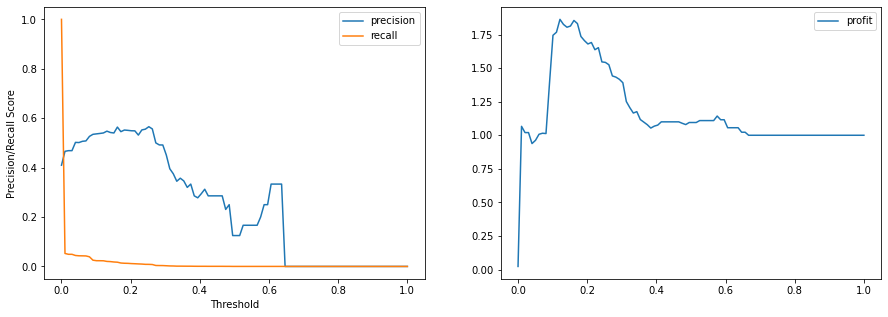

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

x = np.linspace(0,1,100)
p = []
r = []
pf = []

df_hist = pd.read_pickle(f'data/data_file_hist_all_cols.pkl')
df_hist = df_hist[['use_atr','ratio']].drop_duplicates().reset_index(drop=True)

for threshold in x:
    p.append(precision_score(y_test.buy, np.where(scores<threshold,0,1), zero_division=0))
    r.append(recall_score(y_test.buy, np.where(scores<threshold,0,1), zero_division=0))
    pf.append(run_simulator(X_test, np.where(scores<threshold,0,1), True, (2,1), True))

fig,axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(x,p, label='precision')
axs[0].plot(x,r, label='recall')
axs[0].set_xlabel('Threshold')
axs[0].set_ylabel('Precision/Recall Score')
axs[0].legend()
axs[1].plot(x,pf, label='profit')
axs[1].legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

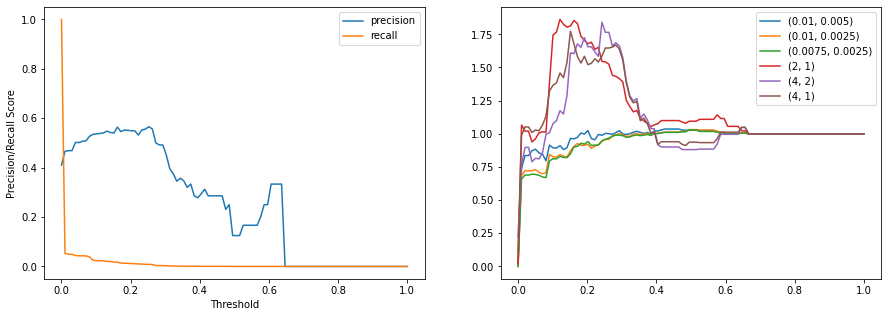

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

x = np.linspace(0,1,100)
p = []
r = []
pfs = []

df_hist = pd.read_pickle(f'data/data_file_hist_all_cols.pkl')
df_hist = df_hist[['use_atr','ratio']].drop_duplicates().reset_index(drop=True)

for threshold in tqdm(x):
    p.append(precision_score(y_test.buy, np.where(scores<threshold,0,1), zero_division=0))
    r.append(recall_score(y_test.buy, np.where(scores<threshold,0,1), zero_division=0))
    pf = []
    for _,v in df_hist.iterrows():
        pf.append(run_simulator(X_test, np.where(scores<threshold,0,1), v['use_atr'], v['ratio'], True))
    pfs.append(pf)

fig,axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(x,p, label='precision')
axs[0].plot(x,r, label='recall')
axs[0].set_xlabel('Threshold')
axs[0].set_ylabel('Precision/Recall Score')
axs[0].legend()

rat = df_hist.ratio.values
pfs = list(zip(*pfs))

for i in range(len(pfs)):
    axs[1].plot(x,pfs[i], label=rat[i])
axs[1].legend()
plt.show()

In [16]:
print(rat[3])
print(np.array(pfs[3]).argmax())
print('Maximized Threshold', x[12])
print('Maximized Profits', pfs[3][12])

(2, 1)
12
Maximized Threshold 0.12121212121212122
Maximized Profits 1.8628392897504258


# Save Ensemble

In [18]:
import pickle
import datetime

timestamp = datetime.datetime.now().strftime('%y%m%d%H%M')
filename = f"models/nm_lrc_ensemble_{timestamp}.pkl"
print(f'Saving model to {filename}...')
pickle.dump(models, open(filename, 'wb'))

Saving model to models/nm_lrc_ensemble_2108111438.pkl...
